#### Imports 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

#### Importing Data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [5]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [6]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [7]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


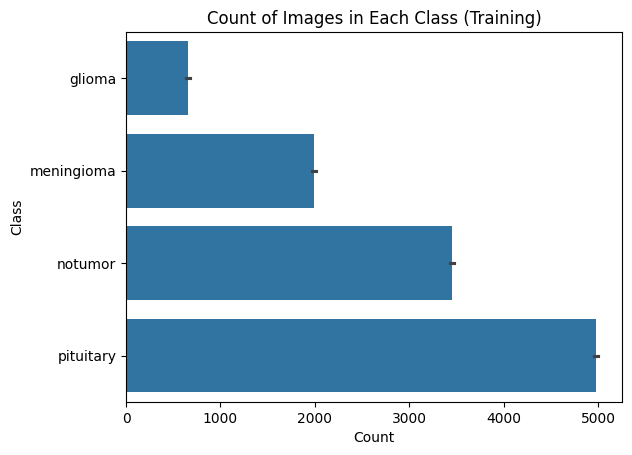

In [8]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

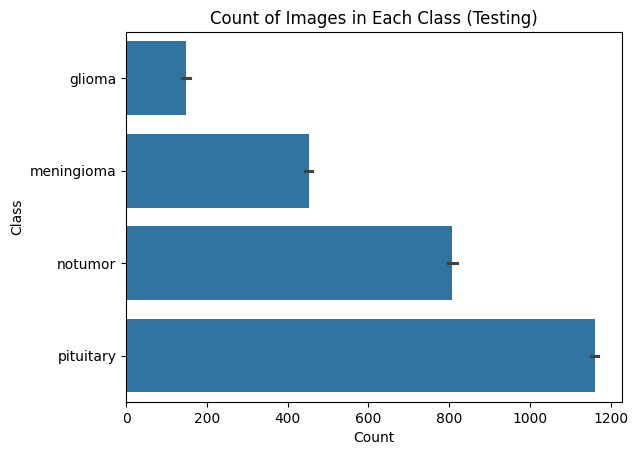

In [9]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

#### Data Preprocessing

In [10]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=True)

# set shuffle equal to True simply for the picture

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [11]:
# Use annomoly detection, the notumor images to the tumor images. Could tell us where the tumor is.

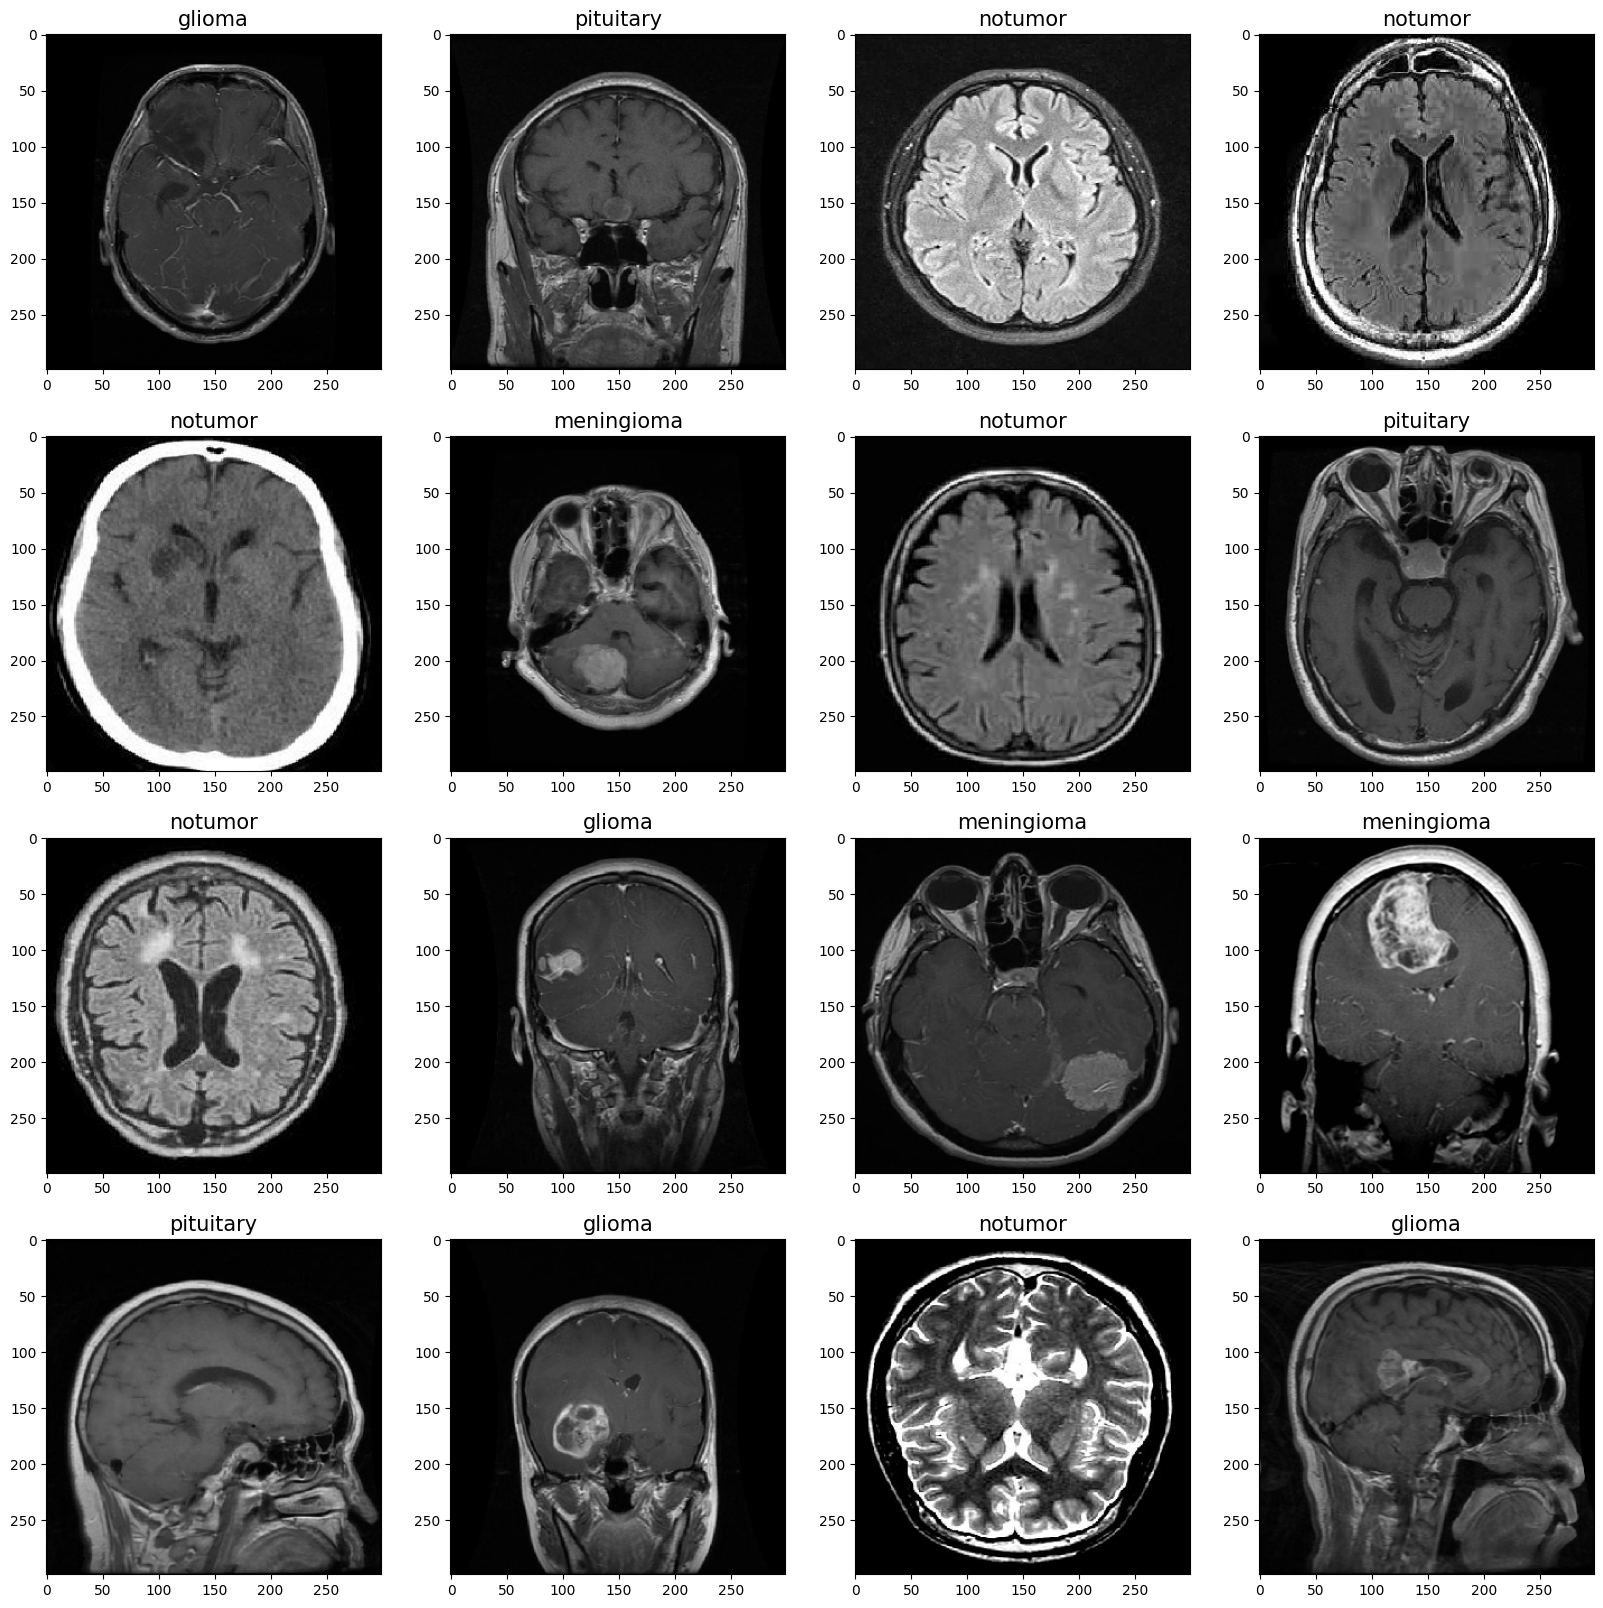

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

In [13]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size,
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

# set shuffle back to false for model and confusion matrix 
# if set to true, then messes up confusion matrix as true labels 
# are also shuffled with the images. 

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

#### Initial CNN

In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 757ms/step - accuracy: 0.7677 - loss: 1.1562
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.9450 - loss: 0.1612
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 252ms/step - accuracy: 0.9900 - loss: 0.0375
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.9982 - loss: 0.0114
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.9995 - loss: 0.0033
82/82 - 29s - 352ms/step - accuracy: 0.9489 - loss: 0.1864
Loss: 0.18638359010219574
Accuracy: 0.9488939642906189


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


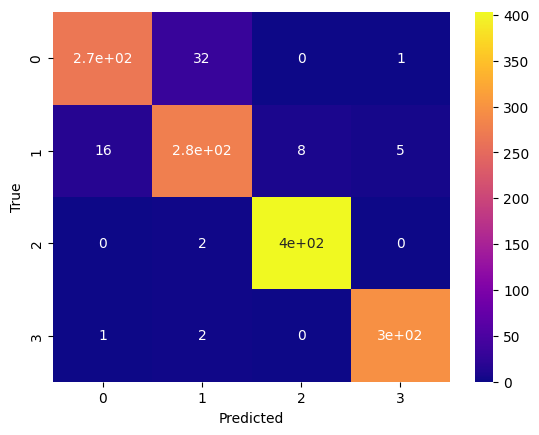

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.91       300
  meningioma       0.88      0.91      0.89       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



In [16]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Hyperparameter Tuning

In [17]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5


C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 618ms/step - accuracy: 0.6857 - loss: 1.7225
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 615ms/step - accuracy: 0.8993 - loss: 0.2889
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 624ms/step - accuracy: 0.9576 - loss: 0.1290
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 645ms/step - accuracy: 0.9842 - loss: 0.0529
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 114s 637ms/step - accuracy: 0.9953 - loss: 0.0204
82/82 - 11s - 130ms/step - accuracy: 0.9458 - loss: 0.1899
Loss: 0.18985961377620697
Accuracy: 0.9458428621292114


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step


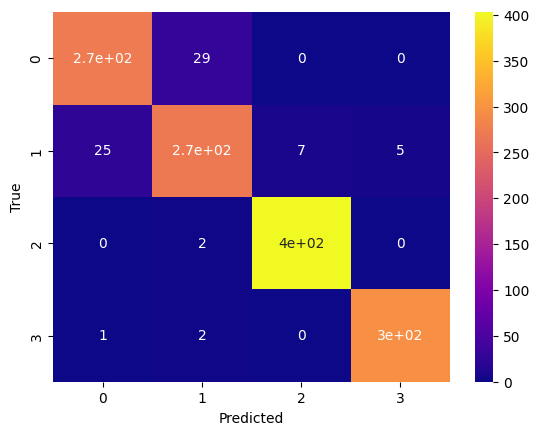

              precision    recall  f1-score   support

      glioma       0.91      0.90      0.91       300
  meningioma       0.89      0.88      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [18]:
y_pred = np.argmax(model.predict(ts_gen), axis=-1)
y_true = ts_gen.classes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap="plasma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

#### Anomaly Dectection Using Isolation Forests

In [19]:
feature_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=-2).output 
    # index=-2 gives Dense(64) layer
)

# building feature extractor from trained CNN

"""
input is the original cnn
output is the second to last layer of the CNN
"""

'\ninput is the original cnn\noutput is the second to last layer of the CNN\n'

In [20]:
model.inputs

[<KerasTensor shape=(None, 299, 299, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_12>]

In [21]:
print(tr_gen.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Extract features from all Normal training images

normal_class_index = tr_gen.class_indices["notumor"] # this is now the anomaly
# a dictionary mapping the calss names 

normal_features = []

for x, y in tr_gen:
    normal_indices = np.where(np.argmax(y, axis=1) == normal_class_index)[0]
    # converts one-hot labels into integer class labels
    # returns indices in the batch coreesponding to notumor class

    print(normal_indices)
    if len(normal_indices) == 0:
        continue
    # skip batches that don't have normal images

    imgs = x[normal_indices]
    # only keep images that belong to the notumor class
    feats = feature_extractor.predict(imgs)
    # pass the images through dense(64) feature extractor
    normal_features.append(feats)

    if len(normal_features) * tr_gen.batch_size >= tr_gen.n:
        break
    # stop after processed roughly all samples 

normal_features = np.vstack(normal_features)
# concentrate all batches vertically --> one big array 
print("Feature Shape:", normal_features.shape)


[ 1  6  7 14 25 26 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[ 0  1  2  6 11 13 15 16 17 22 24 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[ 0  1 10 14 16 19 22 26 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
[ 4  7 10 11 12 18 21 24 26 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[ 1  4  6  9 12 22 25 28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[ 3  7  9 14 25 26 27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[ 0  2  3  5 14 15 21]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[ 0 10 17 19 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[ 1  7 14 21 22]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
[ 8  9 10 12 13 18 19 20 23 26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
[ 3  8  9 10 14 24 27 29 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[ 6 10 16 17 25 28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[ 1  4  7  8 13 14 15 16 20 22 26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[ 2  6  9 12 14 16 17 20 24 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[ 1  4  6  9 11 12 15 23 25 27 28]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[ 1  3  4

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normal_features_scaled = scaler.fit_transform(normal_features)

In [34]:
# Train the Isolation Forest

from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination = 0.01, # percentage of anomalies in notumor, noise
    random_state=42
)

iso.fit(normal_features_scaled)

,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [35]:
# Use it to detext anomalies on any image

def anomaly_score(img):

    feat = feature_extractor.predict(img[None,...])
    # adds a batch dimension --> (1,64) feature vector
    feat_scaled = scaler.transform(feat)
    # scales the vector
    
    score = -iso.decision_function(feat_scaled)[0] # higher = more anomalous
    label = iso.predict(feat_scaled)[0]            # -1 = anomaly, 1 = normal
    return score, label

In [26]:
y_true = []
y_pred = []

ts_gen.reset()

for batch_images, batch_labels in ts_gen:
    for image, tum in zip(batch_images, batch_labels):

        score, pred = anomaly_score(image)
        new_label = np.where(tum == 1)[0][0]

        if pred == -1 and new_label != 2:
            print("Correct Tumor")
        elif pred == -1 and new_label == 2:
            print("Incorrect Tumor")
        elif pred == 1 and new_label != 2:
            print("Incorrect Okie Dokie")
        elif pred == 1 and new_label == 2:
            print("Correct Okie Dokie")

    if ts_gen.batch_index == 0:   # generator wrapped
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Incorrect Okie Dok

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = []
y_pred = []

ts_gen.reset()

for batch_images, batch_labels in ts_gen:

    batch_true_labels = np.argmax(batch_labels, axis=1)
    # convert one-hot labels to integer class indices
    for image, true_label in zip(batch_images, batch_true_labels):

        # get anomaly score adn prediction
        score, pred = anomaly_score(image)

        pred_label = 0 if pred == -1 else 1 # 0=tumor, 1=normal
        true_binary = 0 if true_label != normal_class_index else 1

        y_true.append(true_binary)
        y_pred.append(pred_label)

        if pred == -1 and true_label != normal_class_index:
            print("Correct Tumor")
        elif pred == -1 and true_label == normal_class_index:
            print("Incorrect Tumor")
        elif pred == 1 and true_label != normal_class_index:
            print("Incorrect Okie Dokie")
        elif pred == 1 and true_label == normal_class_index:
            print("Correct Okie Dokie")

    if ts_gen.batch_index == 0:   # generator wrapped
        break


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)  # how many predicted tumors were correct
recall = recall_score(y_true, y_pred)        # how many actual tumors were detected
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Incorrect Okie Dokie
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Incorrect Okie Dok

#### Visualizing Anomaly Detection

In [43]:
# Extract features from all Normal training images

normal_class_index = tr_gen.class_indices["notumor"] # this is now the anomaly
# a dictionary mapping the calss names 

normal_features = []
tumor_features = []

for x, y in tr_gen:

    labels = np.argmax(y, axis=1)

    tumor_indices = np.where(labels != normal_class_index)[0]
    # converts one-hot labels into integer class labels
    # returns indices in the batch coreesponding to notumor class

    print(tumor_indices)
    if len(tumor_indices) == 0:
        continue
    # skip batches that don't have normal images

    imgs = x[tumor_indices]
    # only keep images that belong to the notumor class
    feats = feature_extractor.predict(imgs)
    # pass the images through dense(64) feature extractor
    tumor_features.append(feats)

    if len(tumor_features) * tr_gen.batch_size >= tr_gen.n:
        break
    # stop after processed roughly all samples 

tumor_features = np.vstack(tumor_features)
# concentrate all batches vertically --> one big array 
print("Feature Shape:", tumor_features.shape)

[ 0  1  2  5  6  8  9 11 12 14 15 17 18 20 21 22 23 24 25 26 27 28 29 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 17 19 20 21 22 24 25 26 27
 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
[ 0  5  7  9 10 11 12 13 15 16 17 18 19 20 21 22 23 25 26 27 28 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
[ 1  2  3  4  5  6  7  8 11 12 13 15 16 18 20 21 22 24 25 26 28 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[ 0  1  2  3  6  8  9 10 11 14 15 16 17 18 19 22 23 24 25 26 28 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
[ 1  2  3  4  5  6  7  8  9 10 11 14 18 19 20 22 23 24 25 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
[ 3  4  5  6  7  8  9 10 11 12 13 17 18 19 20 22 23 24 26 27 28 30]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
[ 0  2  3  4  5  7  8  9 13 14 15 16 17 19 20 21 22 24 27 28 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
[ 0  4  5  8 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25 27 28 29 30 31]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tumor_features_scaled = scaler.fit_transform(tumor_features)

In [57]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    contamination = 0.02, # percentage of anomalies in notumor, noise
    random_state=42
)

iso.fit(tumor_features_scaled)

train_scores = -iso.decision_function(tumor_features_scaled)

print("Training scores shape:", train_scores.shape)
print("Score Range:", train_scores.min(), "->", train_scores.max())

Training scores shape: (4117,)
Score Range: -0.2900361343143454 -> 0.22714150396250732


In [58]:
def anomaly_score(img):

    feat = feature_extractor.predict(img[None,...])
    # adds a batch dimension --> (1,64) feature vector
    feat_scaled = scaler.transform(feat)
    # scales the vector
    
    score = -iso.decision_function(feat_scaled)[0] # higher = more anomalous
    label = iso.predict(feat_scaled)[0]            # -1 = anomaly, 1 = normal
    return score, label

In [59]:
test_scores = []
test_true = []

ts_gen.reset()

for batch_images, batch_labels in ts_gen:
    batch_true_labels = np.argmax(batch_labels, axis=1)

    for image, true_label in zip(batch_images, batch_true_labels):
        feat = feature_extractor.predict(image[None,...])
        feat_scaled = scaler.transform(feat)
        score = -iso.decision_function(feat_scaled)[0]

        test_scores.append(score)
        test_true.append(1 if true_label == normal_class_index else 0)

    if ts_gen.batch_index == 0:
        break

test_scores = np.array(test_scores)
test_true = np.array(test_true)

threshold = np.percentile(train_scores, 85)
print("Threshold:", threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

In [60]:
y_pred = (test_scores >= threshold).astype(int)   # 1 = anomaly (notumor)
y_true = test_true

In [ ]:
# y_true = []
# y_pred = []

# ts_gen.reset()

# for batch_images, batch_labels in ts_gen:

#     batch_true_labels = np.argmax(batch_labels, axis=1)
#     # convert one-hot labels to integer class indices
#     for image, true_label in zip(batch_images, batch_true_labels):

#         # get anomaly score adn prediction
#         score, pred = anomaly_score(image)

#         # IF: -1 = anomaly = Notumor -> 1
#         # If: 1 = normal = TUmor -> 0
#         pred_label = 1 if pred == -1 else 0

#         # Ture label: 1 = notumor, 0 = tumor
#         true_binary = 1 if true_label == normal_class_index else 0

#         y_true.append(true_binary)
#         y_pred.append(pred_label)

#     if ts_gen.batch_index == 0:   # generator wrapped
#         break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

In [61]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8772
Precision: 0.7285
Recall: 0.9605
F1 Score: 0.8285


In [62]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))

[[761 145]
 [ 16 389]]
              precision    recall  f1-score   support

           0     0.9794    0.8400    0.9043       906
           1     0.7285    0.9605    0.8285       405

    accuracy                         0.8772      1311
   macro avg     0.8539    0.9002    0.8664      1311
weighted avg     0.9019    0.8772    0.8809      1311



#### Anonaly Detection, autoencoders. 

In [27]:
# laten_dim = 64

# encoder = models.Sequential([
#     layers.Conv2D(64, (3,3), activation="relu", input_shape=(299,299,3)),
#     layers.Conv2D(32, (3,3), activation="relu"),
#     layers.Conv2D(16, (3,3), activation="relu"),
#     layers.Flatten(),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(32, activation="relu"),
#     layers.Dense(laten_dim*2)
# ], name="encoder")

In [28]:
# class Sampling(layers.Layer):
#     def call(self, z_params):
        
#         z_mean, z_log_var = tf.split(z_params, 2, axis=1)
#         # The endoder outputs (z_mean, z_log_var) stacked together,
#         # this line splits them into two tensors

#         eps = tf.random.normal(shape=tf.shape(z_mean))
#         # Generate random noise with the same shape as z_mean
        
#         return z_mean + tf.exp(0.5 * z_log_var) * eps
#         # This is the reparameterization trick:
#         #  - tf.exp = standard deviation
#         #  - muttiply by noise to introduce randomness
#         #  - add mean to shift the distribution
    
"""
Reparameterization trick is required to make the VAE trainable. 

It takes the encoder's output [z_mean, z_log_var], and uses them 
 to produce a vector to be fed into the decoder 

This needs to be done becasue VAE learns distribution, not a single point,
 the model then samples a point from this distribution

Sampling is not differentiable, and since NNs train on gradients, we need
 to rewrite the sampling in a differentiable way (z= mean + std * eps)

"""

"\nReparameterization trick is required to make the VAE trainable. \n\nIt takes the encoder's output [z_mean, z_log_var], and uses them \n to produce a vector to be fed into the decoder \n\nThis needs to be done becasue VAE learns distribution, not a single point,\n the model then samples a point from this distribution\n\nSampling is not differentiable, and since NNs train on gradients, we need\n to rewrite the sampling in a differentiable way (z= mean + std * eps)\n\n"

In [29]:
# decoder = models.Sequential([
#     layers.Dense(294*294*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((294, 294, 64)),
#     layers.Conv2DTranspose(64, 2, activation="relu"),
#     layers.Conv2DTranspose(32, 2, activation="relu"),
#     layers.Conv2DTranspose(16, 2, activation="relu"),
#     layers.Conv2DTranspose(3, 3, activation="sigmoid"),
# ], name="decoder")

In [30]:
# decoder = models.Sequential([
#     layers.Dense(19*19*64, activation="relu", input_shape=(laten_dim,)),
#     layers.Reshape((19,19,64)),
#     layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu"),
#     layers.Conv2D(3, 3, padding="same", activation="sigmoid"),
#     layers.Cropping2D(((2,3), (2,3))),
# ], name="decoder")

In [31]:
# class VAE(keras.Model):
#     def __init__(self, encoder, decoder):
#         super().__init__()
#         self.encoder = encoder
#         self.decoder = decoder
#         self.sampler = Sampling()

#         self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
#     def train_step(self, data):
        
#         x, _ = data

#         self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

#         with tf.GradientTape() as tape:
#             z_params = self.encoder(x)
#             z_mean, z_log_var = tf.split(z_params, 2, axis=1)

#             z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)

#             z_params_clipped = tf.concat([z_mean, z_log_var], axis=1)

#             z = self.sampler(z_params_clipped)

#             reconstruction = self.decoder(z)

#             recon_loss = tf.reduce_mean(tf.square(x -reconstruction))
#             recon_loss = tf.reduce_sum(recon_loss, axis=list(range(1, len(recon_loss.shape))))
#             recon_loss = tf.reduce_mean(tf.reduce_sum(recon_loss))

#             kl_loss = -0.5 * tf.reduce_mean(
#                 tf.reduce_sum(
#                     1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
#             )

        #     #beta = 0.1

        #     total_loss = recon_loss + self.beta * kl_loss
    
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # return {"loss": total_loss,
        #         "reconstruction_loss": recon_loss,
        #         "kl_loss": kl_loss
        #         }

In [32]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer="adam")
# vae.fit(tr_gen, epochs=1, batch_size=64)
# vae.predict(ts_gen)

The mse loss is alright, but the kl_loss is being collapsed down to zero, nmeaning that it's getting overshadowed by the reconstruction loss, fix that by giving it a weight. Also, change the latent_dim to something bigger, maybe 16 or 32? the 2-dim sapce is too small for the images to actually learn something. 